# Applying statistical modeling and machine learning to perform time-series forecasting.

Tamara Louie  
PyData LA  
October 2018

# Time-series data due diligence

## Read in my data
**Please download from http://insideairbnb.com/get-the-data.html the following CSV file (23 MB) under the "Los Angeles" section:**

	reviews.csv
  

You should have **reviews.csv** stored somewhere locally. 

Run the cell below, and click on the button **Choose Files**, to select your **reviews.csv** to upload.  

*Note: It will take some time to upload this data, so please start your upload and this upload will run for a couple of minutes.*

## Import some relevant packages
Ideally, one should set up their own virtual environment and determine the versions of each library that they are using.  Here, we will assume that the colaboratory environment has some shared environment with access to common Python libraries and the ability to install other libraries necessary.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime


# set formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# read in CSV file data
df = pd.read_csv('reviews.csv')

## Look at my data
- How many rows are in the dataset?
- How many columns are in this dataset?
- What data types are the columns?
- Is the data complete? Are there nulls? Do we have to infer values?
- What is the definition of these columns?
- What are some other caveats to the data?


In [3]:
# look at data
display(df.head())

# look a shape of data
display(df.shape)

# display descriptive statistics
display(df.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

,listing_id,date
0,109,2011-08-15
1,109,2016-05-15
2,2708,2014-06-09
3,2708,2014-06-23
4,2708,2015-07-25


(1095947, 2)

,listing_id
count,1.095947e+06
mean,1.864743e+07
std,1.338226e+07
min,1.090000e+02
25%,7.112899e+06
50%,1.726771e+07
75%,2.770018e+07
85%,3.462679e+07
95%,4.400386e+07
99%,4.926239e+07


In [11]:
# look at data types. Ideally look at all rows. Only look at first five here for minimal output.
df.iloc[:5,:].dtypes

listing_id     int64
date          object
dtype: object

In [13]:

# see if any columns have nulls. Ideally look at all rows. Only look at first five here for minimal output.
print(df.iloc[:5,:].isnull().any())

listing_id    False
date          False
dtype: bool


## What are some questions I can answer with this data?

Understand the limitations of your data and what potential questions can be answered by data is important.  These questions can reduce, expand, or modify the scope of your project.

If you defined a scope or goal for your project before digging into the data, this might be a good time to revisit it.

**Data.** We have daily count of reviews for given listing ids for given dates.

**Questions I could try to answer. **

*   Forecast future number of reviews for the Los Angeles area.
* Forecast the future number of reviews for specific listings in the Los Angeles area.

## What techniques may help answer these questions?
### Statistical models
*   **Ignore the time-series aspect completely and model using traditional statistical modeling toolbox.** 
  *   *Examples.* Regression-based models.  
*   **Univariate statistical time-series modeling.**
  *   *Examples.* Averaging and smoothing models, ARIMA models.
*   **Slight modifications to univariate statistical time-series modeling.**
  *    *Examples.* External regressors, multi-variate models.
*   **Additive or component models.**
  *  *Examples.* Facebook Prophet package.
*   **Structural time series modeling.**
  *    *Examples.* Bayesian structural time series modeling, hierarchical time series modeling.

### Machine learning models

*   **Ignore the time-series aspect completely and model using traditional machine learning modeling toolbox.** 
  *   *Examples.* Support Vector Machines (SVMs), Random Forest Regression, Gradient-Boosted Decision Trees (GBDTs).
*   **Hidden markov models (HMMs).**
*   **Other sequence-based models.**
*   **Gaussian processes (GPs).**
*   **Recurrent neural networks (RNNs).**
  
### Additional data considerations before choosing a model
*   Whether or not to incorporate external data
*   Whether or not to keep as univariate or multivariate (i.e., which features and number of features)
*   Outlier detection and removal
*   Missing value imputation

# Let's analyze some time-series data!

- [Link 1](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
- [Link 2](https://content.nexosis.com/blog/methods-of-demand-forecasting-bsts-prophet)

## Process my data

In [14]:
# Rename columns
df = df.rename(columns = {'date': 'ds', 'listing_id': 'ts'})

# Group data by number of listings per date
df_example = df.groupby(by = 'ds').agg({'ts': 'count'})

# Change index to datetime
df_example.index = pd.to_datetime(df_example.index)

# Set frequency of time series
df_example = df_example.asfreq(freq='1D')

# Sort the values
df_example = df_example.sort_index(ascending = True)

# Fill values with 0
df_example = df_example.fillna(value = 0)

# Show the end of the data
display(df_example.tail())

,ts
ds,
2021-09-05,613.0
2021-09-06,914.0
2021-09-07,404.0
2021-09-08,149.0
2021-09-09,16.0


## Plot my data
- There does appear to be an overall increasing trend. 
- There appears to be some differences in the variance over time. 
- There may be some seasonality (i.e., cycles) in the data.
- Not sure about outliers.

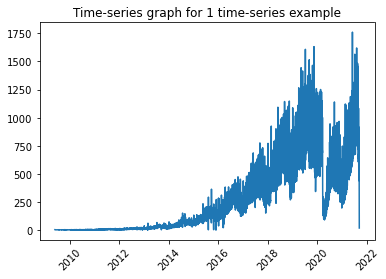

In [15]:
# Plot time series data
f, ax = plt.subplots(1,1)
ax.plot(df_example['ts'])

# Add title
ax.set_title('Time-series graph for 1 time-series example')

# Rotate x-labels
ax.tick_params(axis = 'x', rotation = 45)

# Show graph
plt.show()
plt.close()

## Look at stationarity
Most time-series models assume that the underlying time-series data is **stationary**.  This assumption gives us some nice statistical properties that allows us to use various models for forecasting.

**Stationarity** is a statistical assumption that a time-series has:
*   **Constant mean**
*   **Constant variance**
*   **Autocovariance does not depend on time**

More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past.  This general statement holds for most training data and modeling tasks.

**There are some good diagrams and explanations on stationarity [here](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/) and [here](https://people.duke.edu/~rnau/411diff.htm).**

Sometimes we need to transform the data in order to make it stationary.  However, this  transformation then calls into question if this data is truly stationary and is suited to be modeled using these techniques.

**Looking at our data:**
- Rolling mean and standard deviation look like they change over time.  There may be some de-trending and removing seasonality involved. Based on **Dickey-Fuller test**, because p = 0.31, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that we fail to reject the null hypothesis that our **time series is not stationary**.

In [18]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

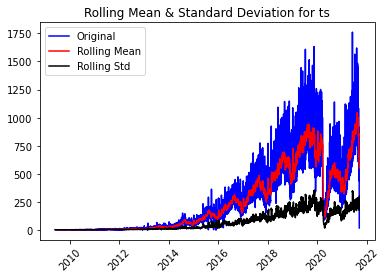

Results of Dickey-Fuller Test:
Test Statistic                   -2.221410
p-value                           0.198567
# Lags Used                      32.000000
Number of Observations Used    4457.000000
Critical Value (1%)              -3.431818
Critical Value (5%)              -2.862189
Critical Value (10%)             -2.567115
dtype: float64


In [19]:
test_stationarity(df = df_example, ts = 'ts')

## Correct for stationarity

It is common for time series data to have to correct for non-stationarity. 

2 common reasons behind non-stationarity are:

1. **Trend** – mean is not constant over time.
2. **Seasonality** – variance is not constant over time.

There are ways to correct for trend and seasonality, to make the time series stationary.

**What happens if you do not correct for these things?**

Many things can happen, including:
- Variance can be mis-specified
- Model fit can be worse.  
- Not leveraging valuable time-dependent nature of the data.  

Here are some resources on the pitfalls of using traditional methods for time series analysis.  
[Quora link](https://www.quora.com/Why-cant-you-use-linear-regression-for-time-series-data)  
[Quora link](https://www.quora.com/Data-Science-Can-machine-learning-be-used-for-time-series-analysis)  


## Eliminating trend and seasonality
*   **Transformation**
  *   *Examples.* Log, square root, etc.
  *   We are going to look at log.
*   **Smoothing**
  *  *Examples.* Weekly average, monthly average, rolling averages.
  *   We are going to look at weekly average.
*   **Differencing**
  *  *Examples.* First-order differencing.
  *   We are going to look at first-order differencing.
*   **Polynomial Fitting**
  *  *Examples.* Fit a regression model.
*   **Decomposition**

## Transformation, Smoothing, and Differencing
**Looking at our data:**
- Applying log transformation, weekly moving average smoothing, and differencing made the data more stationary over time. Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

In [20]:
def plot_transformed_data(df, ts, ts_transform):
  """
  Plot transformed and original time series data
  """
  # Plot time series data
  f, ax = plt.subplots(1,1)
  ax.plot(df[ts])
  ax.plot(df[ts_transform], color = 'red')

  # Add title
  ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
  ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
  ax.legend([ts, ts_transform])
  
  plt.show()
  plt.close()

/var/folders/39/glh0vc5x3qq23jgtd82s68200000gn/T/ipykernel_83174/3128852333.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7,
/var/folders/39/glh0vc5x3qq23jgtd82s68200000gn/T/ipykernel_83174/3128852333.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts_log'] - df_example_transform['ts_log_ewma']


,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
ds,,,,,,,,,
2010-10-06,1.0,0.000000,0.297063,1.428571,-0.693147,-0.428571,-0.297063,0.000000,0.000000
2010-10-07,1.0,0.000000,0.198042,1.285714,0.000000,-0.285714,-0.198042,0.000000,0.000000
2011-01-23,1.0,0.000000,0.511931,2.000000,-1.098612,-1.000000,-0.511931,0.000000,0.000000
2011-03-15,4.0,1.386294,0.610952,2.714286,-0.810930,1.285714,0.775342,0.399617,0.986677
2011-03-16,2.0,0.693147,0.610952,2.714286,-0.693147,-0.714286,0.082195,0.470484,0.222663


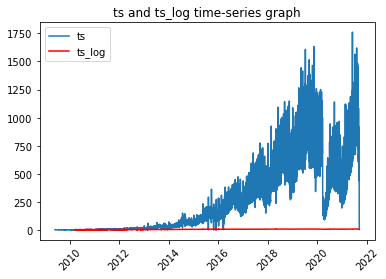

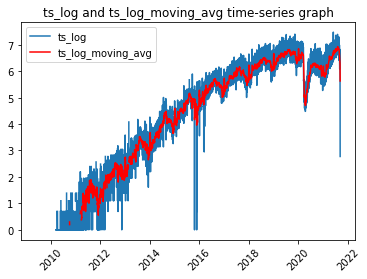

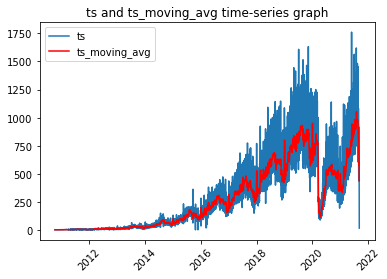

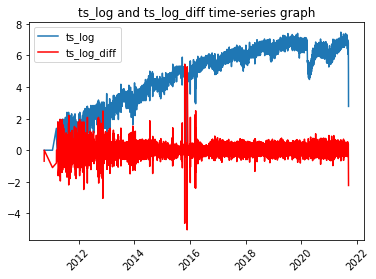

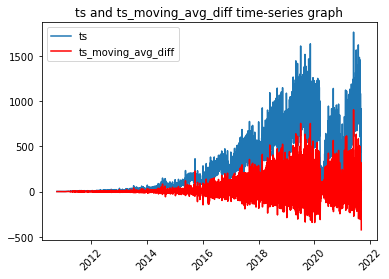

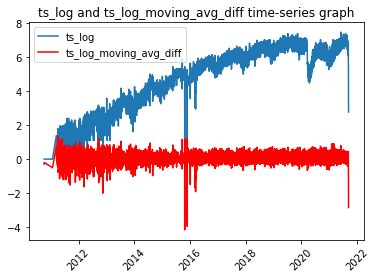

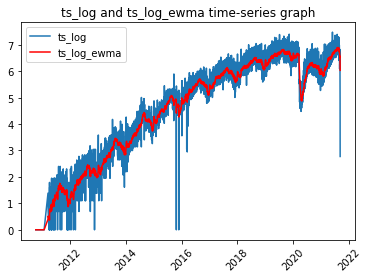

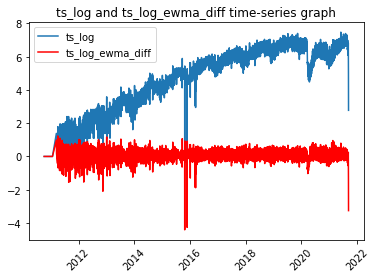

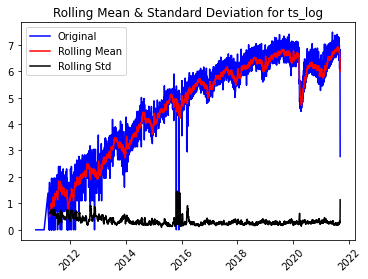

Results of Dickey-Fuller Test:
Test Statistic                   -2.218972
p-value                           0.199432
# Lags Used                      29.000000
Number of Observations Used    3667.000000
Critical Value (1%)              -3.432135
Critical Value (5%)              -2.862329
Critical Value (10%)             -2.567190
dtype: float64


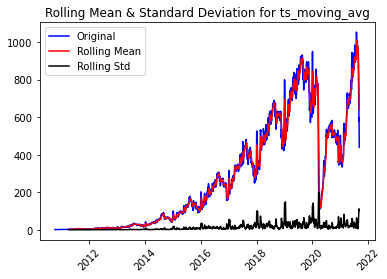

Results of Dickey-Fuller Test:
Test Statistic                   -2.135113
p-value                           0.230632
# Lags Used                      30.000000
Number of Observations Used    3666.000000
Critical Value (1%)              -3.432135
Critical Value (5%)              -2.862329
Critical Value (10%)             -2.567190
dtype: float64


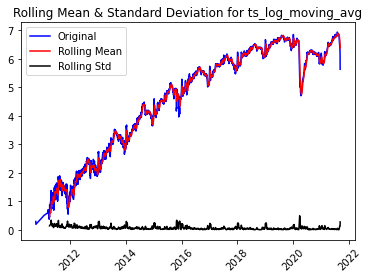

Results of Dickey-Fuller Test:
Test Statistic                   -2.200362
p-value                           0.206114
# Lags Used                      28.000000
Number of Observations Used    3668.000000
Critical Value (1%)              -3.432134
Critical Value (5%)              -2.862328
Critical Value (10%)             -2.567190
dtype: float64


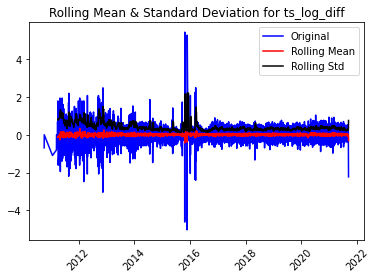

Results of Dickey-Fuller Test:
Test Statistic                -1.253533e+01
p-value                        2.378642e-23
# Lags Used                    2.800000e+01
Number of Observations Used    3.668000e+03
Critical Value (1%)           -3.432134e+00
Critical Value (5%)           -2.862328e+00
Critical Value (10%)          -2.567190e+00
dtype: float64


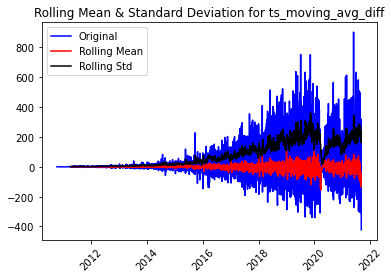

Results of Dickey-Fuller Test:
Test Statistic                -9.744727e+00
p-value                        8.314291e-17
# Lags Used                    2.800000e+01
Number of Observations Used    3.668000e+03
Critical Value (1%)           -3.432134e+00
Critical Value (5%)           -2.862328e+00
Critical Value (10%)          -2.567190e+00
dtype: float64


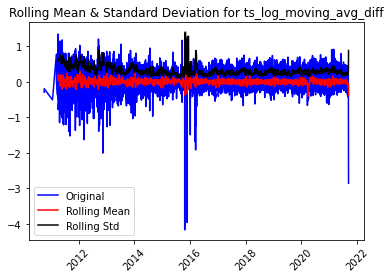

Results of Dickey-Fuller Test:
Test Statistic                -1.225421e+01
p-value                        9.390526e-23
# Lags Used                    2.900000e+01
Number of Observations Used    3.667000e+03
Critical Value (1%)           -3.432135e+00
Critical Value (5%)           -2.862329e+00
Critical Value (10%)          -2.567190e+00
dtype: float64


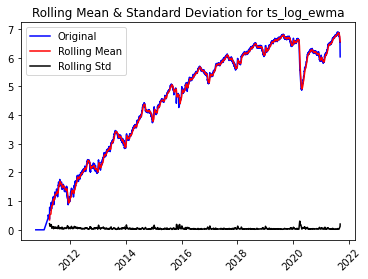

Results of Dickey-Fuller Test:
Test Statistic                   -2.252407
p-value                           0.187777
# Lags Used                      30.000000
Number of Observations Used    3666.000000
Critical Value (1%)              -3.432135
Critical Value (5%)              -2.862329
Critical Value (10%)             -2.567190
dtype: float64


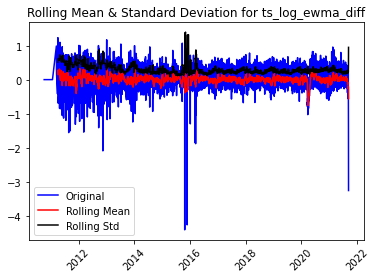

Results of Dickey-Fuller Test:
Test Statistic                -9.954328e+00
p-value                        2.467079e-17
# Lags Used                    2.900000e+01
Number of Observations Used    3.667000e+03
Critical Value (1%)           -3.432135e+00
Critical Value (5%)           -2.862329e+00
Critical Value (10%)          -2.567190e+00
dtype: float64


In [21]:
# Transformation - log ts
df_example['ts_log'] = df_example['ts'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
df_example['ts_log_moving_avg'] = df_example['ts_log'].rolling(window = 7,
                                                               center = False).mean()

# Transformation - 7-day moving average ts
df_example['ts_moving_avg'] = df_example['ts'].rolling(window = 7,
                                                       center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
# df_example['ts_log_diff'] = df_example['ts_log'] - df_example['ts_log'].shift()
df_example['ts_log_diff'] = df_example['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
df_example['ts_moving_avg_diff'] = df_example['ts'] - df_example['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example['ts_log_moving_avg_diff'] = df_example['ts_log'] - df_example['ts_log_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example_transform = df_example.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged ts and logged EWMA ts
df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts_log'] - df_example_transform['ts_log_ewma']

# Display data
display(df_example_transform.head())

# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_ewma_diff')

## Decomposition: trend, seasonality, residuals
**Looking at our data:**
- De-trending and de-seasonalizing made the data (i.e., the residuals) more stationary over time. Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

In [22]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series data
  """
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
  plt.show()
  plt.close()
  
  return

/Users/home/bin/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


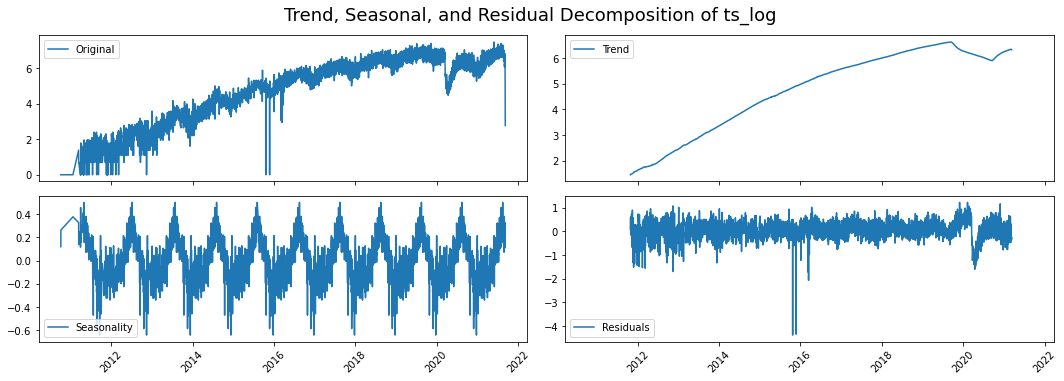

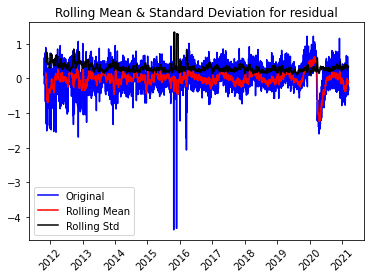

Results of Dickey-Fuller Test:
Test Statistic                -6.637659e+00
p-value                        5.510445e-09
# Lags Used                    2.900000e+01
Number of Observations Used    3.303000e+03
Critical Value (1%)           -3.432331e+00
Critical Value (5%)           -2.862415e+00
Critical Value (10%)          -2.567236e+00
dtype: float64


In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_example_transform['ts_log'], period = 365)

df_example_transform.loc[:,'trend'] = decomposition.trend
df_example_transform.loc[:,'seasonal'] = decomposition.seasonal
df_example_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_example_transform, 
                   ts = 'ts_log', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = df_example_transform.dropna(), ts = 'residual')

# Let us model some time-series data! Finally! ARIMA models.

We will be doing an example here! We can use ARIMA models when we know there is dependence between values and we can leverage that information to forecast.

**ARIMA = Auto-Regressive Integrated Moving Average**.   
**Assumptions.** The time-series is stationary.  
**Depends on:**  
  **1. Number of AR (Auto-Regressive) terms (p).**  
  **2. Number of I (Integrated or Difference) terms (d).**  
  **3. Number of MA (Moving Average) terms (q).**  

## ACF and PACF Plots
**How do we determine p, d, and q?**
For p and q, we can use ACF and PACF plots (below).

**Autocorrelation Function (ACF).** Correlation between the time series with a lagged version of itself (e.g., correlation of Y(t) with Y(t-1)).

**Partial Autocorrelation Function (PACF).** Additional correlation explained by each successive lagged term.

**How do we interpret ACF and PACF plots?**
- p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
- q – Lag value where the ACF chart crosses the upper confidence interval for the first time.


In [27]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

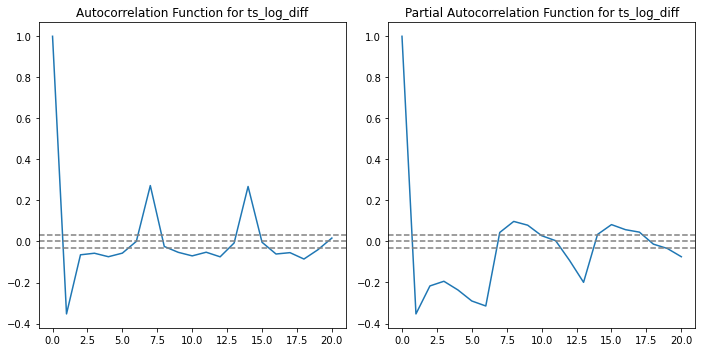

In [28]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

# determine ACF and PACF
lag_acf = acf(np.array(df_example_transform['ts_log_diff']), nlags = 20)
lag_pacf = pacf(np.array(df_example_transform['ts_log_diff']), nlags = 20)

# plot ACF and PACF
plot_acf_pacf(df = df_example_transform, ts = 'ts_log_diff')

In [41]:
def run_arima_model(df, ts, p, d, q):
  """
  Run ARIMA model
  """
  from statsmodels.tsa.arima.model import ARIMA

  # fit ARIMA model on time series
  model = ARIMA(df[ts], order=(p, d, q))  
  results_ = model.fit()  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[ts][-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[ts]))
  
  # plot fit
  plt.plot(df[ts])
  plt.plot(results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))
  
  plt.show()
  plt.close()
  
  return results_

/Users/home/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/home/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/home/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


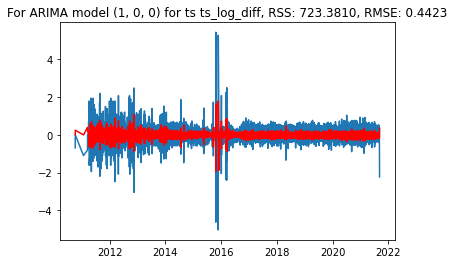

/Users/home/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/home/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/home/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


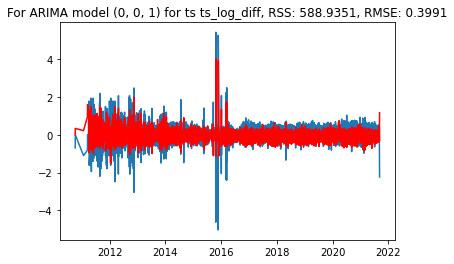

/Users/home/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/home/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/home/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


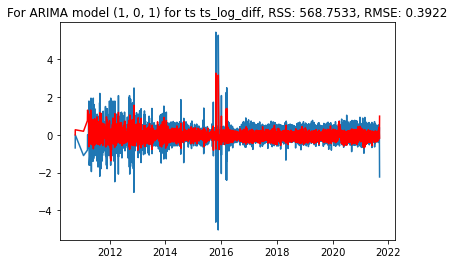

In [42]:
# Note: I do the differencing in the transformation of the data 'ts_log_diff'
# AR model with 1st order differencing - ARIMA (1,0,0)
model_AR = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_MA = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 0, 
                           d = 0, 
                           q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_MA = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 1)

# Let us model some time-series data! Finally! Facebook Prophet package.

We will be doing an example here! Installing the necessary packages might take a couple of minutes.  In the meantime, I can talk a bit about [Facebook Prophet](https://facebook.github.io/prophet/), a tool that allows folks to forecast using additive or component models relatively easily.  It can also include things like:
* Day of week effects
* Day of year effects
* Holiday effects
* Trend trajectory
* Can do MCMC sampling

In [43]:
from fbprophet import Prophet
import datetime
from datetime import datetime

In [44]:
def days_between(d1, d2):
    """Calculate the number of days between two dates.  D1 is start date (inclusive) and d2 is end date (inclusive)"""
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days + 1)

In [45]:
# Inputs for query

date_column = 'dt'
metric_column = 'ts'
table = df_example
start_training_date = '2010-07-03'
end_training_date = '2018-09-08'
start_forecasting_date = '2018-09-09'
end_forecasting_date = '2018-12-31'
year_to_estimate = '2018'

# Inputs for forecasting

# future_num_points
# If doing different time intervals, change future_num_points
future_num_points = days_between(start_forecasting_date, end_forecasting_date)

cap = None # 2e6

# growth: default = 'linear'
# Can also choose 'logistic'
growth = 'linear'

# n_changepoints: default = 25, uniformly placed in first 80% of time series
n_changepoints = 25 

# changepoint_prior_scale: default = 0.05
# Increasing it will make the trend more flexible
changepoint_prior_scale = 0.05 

# changpoints: example = ['2016-01-01']
changepoints = None 

# holidays_prior_scale: default = 10
# If you find that the holidays are overfitting, you can adjust their prior scale to smooth them
holidays_prior_scale = 10 

# interval_width: default = 0.8
interval_width = 0.8 

# mcmc_samples: default = 0
# By default Prophet will only return uncertainty in the trend and observation noise.
# To get uncertainty in seasonality, you must do full Bayesian sampling. 
# Replaces typical MAP estimation with MCMC sampling, and takes MUCH LONGER - e.g., 10 minutes instead of 10 seconds.
# If you do full sampling, then you will see the uncertainty in seasonal components when you plot:
mcmc_samples = 0

# holiday: default = None
# thanksgiving = pd.DataFrame({
#   'holiday': 'thanksgiving',
#   'ds': pd.to_datetime(['2014-11-27', '2015-11-26',
#                         '2016-11-24', '2017-11-23']),
#   'lower_window': 0,
#   'upper_window': 4,
# })
# christmas = pd.DataFrame({
#   'holiday': 'christmas',
#   'ds': pd.to_datetime(['2014-12-25', '2015-12-25', 
#                         '2016-12-25','2017-12-25']),
#   'lower_window': -1,
#   'upper_window': 0,
# })
# holidays = pd.concat((thanksgiving,christmas))
holidays = None

daily_seasonality = True

In [46]:
# get relevant data - note: could also try this with ts_log_diff
df_prophet = df_example_transform[['ts']] # can try with ts_log_diff

# reset index
df_prophet = df_prophet.reset_index()

# rename columns
df_prophet = df_prophet.rename(columns = {'ds': 'ds', 'ts': 'y'}) # can try with ts_log_diff

# Change 'ds' type from datetime to date (necessary for FB Prophet)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Change 'y' type to numeric (necessary for FB Prophet)
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='ignore')

# Remove any outliers
# df.loc[(df_['ds'] > '2016-12-13') & (df_['ds'] < '2016-12-19'), 'y'] = None

In [47]:
def create_daily_forecast(df,
#                           cap,
                          holidays,
                          growth,
                          n_changepoints = 25,
                          changepoint_prior_scale = 0.05,
                          changepoints = None,
                          holidays_prior_scale = 10,
                          interval_width = 0.8,
                          mcmc_samples = 1,
                          future_num_points = 10, 
                          daily_seasonality = True):
  """
  Create forecast
  """
  
  # Create copy of dataframe
  df_ = df.copy()

  # Add in growth parameter, which can change over time
  #     df_['cap'] = max(df_['y']) if cap is None else cap

  # Create model object and fit to dataframe
  m = Prophet(growth = growth,
              n_changepoints = n_changepoints,
              changepoint_prior_scale = changepoint_prior_scale,
              changepoints = changepoints,
              holidays = holidays,
              holidays_prior_scale = holidays_prior_scale,
              interval_width = interval_width,
              mcmc_samples = mcmc_samples, 
              daily_seasonality = daily_seasonality)

  # Fit model with dataframe
  m.fit(df_)

  # Create dataframe for predictions
  future = m.make_future_dataframe(periods = future_num_points)
  #     future['cap'] = max(df_['y']) if cap is None else cap

  # Create predictions
  fcst = m.predict(future)

  # Plot
  m.plot(fcst);
  m.plot_components(fcst)

  return fcst

Initial log joint probability = -105.428
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          7430    0.00124979       104.845      0.6878      0.6878      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7434.52    0.00133957       161.539           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7439.62     0.0020769       149.612      0.3514           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     387       7443.22   0.000575274       255.397   8.608e-06       0.001      528  LS failed, Hessian reset 
     399       7443.66   6.45342e-05       89.8701      0.2095      0.2095      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7444.82   0.000621674    

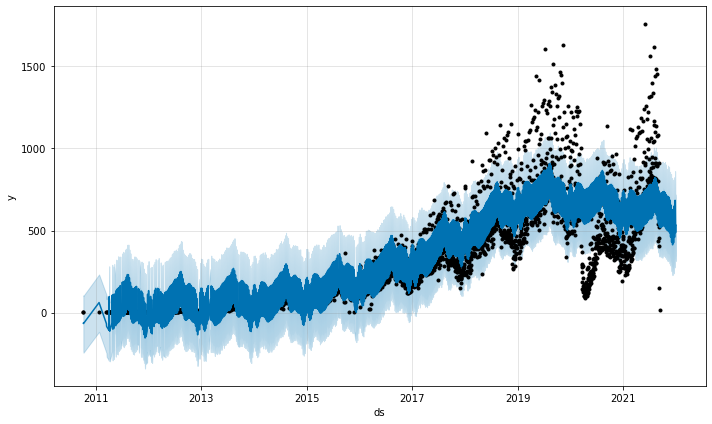

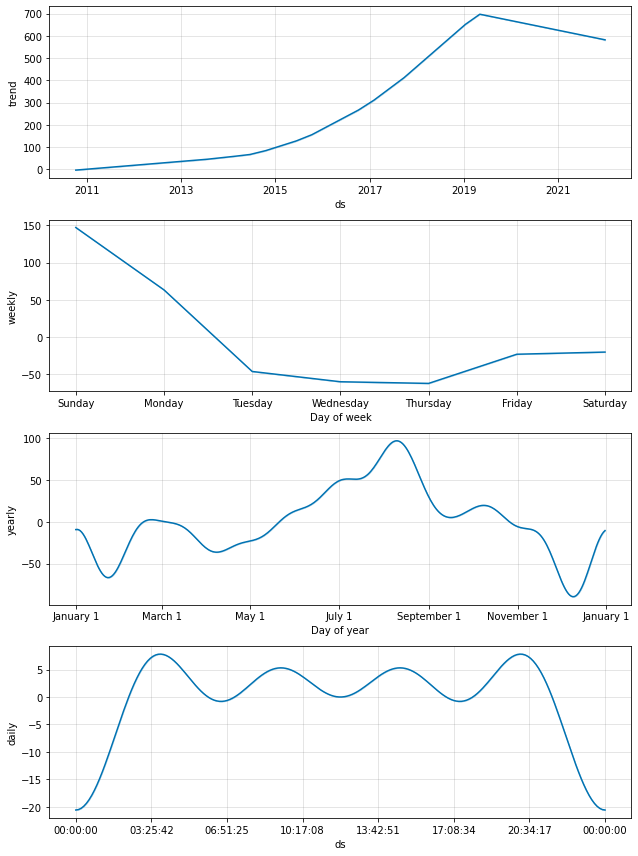

In [48]:
fcst = create_daily_forecast(df_prophet,
#                              cap,
                             holidays,
                             growth,
                             n_changepoints,
                             changepoint_prior_scale,
                             changepoints, 
                             holidays_prior_scale,
                             interval_width,
                             mcmc_samples,
                             future_num_points, 
                             daily_seasonality)

In [49]:
def calculate_mape(y_true, y_pred):
    """ Calculate mean absolute percentage error (MAPE)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_mpe(y_true, y_pred):
    """ Calculate mean percentage error (MPE)"""
    return np.mean((y_true - y_pred) / y_true) * 100

def calculate_mae(y_true, y_pred):
    """ Calculate mean absolute error (MAE)"""
    return np.mean(np.abs(y_true - y_pred)) * 100

def calculate_rmse(y_true, y_pred):
    """ Calculate root mean square error (RMSE)"""
    return np.sqrt(np.mean((y_true - y_pred)**2))

def print_error_metrics(y_true, y_pred):
    print('MAPE: %f'%calculate_mape(y_true, y_pred))
    print('MPE: %f'%calculate_mpe(y_true, y_pred))
    print('MAE: %f'%calculate_mae(y_true, y_pred))
    print('RMSE: %f'%calculate_rmse(y_true, y_pred))
    return

In [50]:
print_error_metrics(y_true = df_prophet['y'], y_pred = fcst['yhat'])

MAPE: 330.855031
MPE: 41.516074
MAE: 9198.347826
RMSE: 140.637290


# Let us model some time-series data! Finally! LSTM for regression

We will be going through an example here.

Also, here are some resources on recurrent neural networks (RNN) and Long Short-Term Memory networks (LSTMs):
* [Link 1](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
* [Link 2](https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f)
* [Link 3](http://adventuresinmachinelearning.com/recurrent-neural-networks-lstm-tutorial-tensorflow/)

In [51]:
def do_lstm_model(df, 
                  ts, 
                  look_back, 
                  epochs, 
                  type_ = None, 
                  train_fraction = 0.67):
  """
   Create LSTM model
   Source: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
  """
  # Import packages
  import numpy
  import matplotlib.pyplot as plt
  from pandas import read_csv
  import math
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.metrics import mean_squared_error

  # Convert an array of values into a dataset matrix
  def create_dataset(dataset, look_back=1):
    """
    Create the dataset
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), 0]
      dataX.append(a)
      dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

  # Fix random seed for reproducibility
  numpy.random.seed(7)

  # Get dataset
  dataset = df[ts].values
  dataset = dataset.astype('float32')

  # Normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset.reshape(-1, 1))
  
  # Split into train and test sets
  train_size = int(len(dataset) * train_fraction)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
  # Reshape into X=t and Y=t+1
  look_back = look_back
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  
  # Reshape input to be [samples, time steps, features]
  if type_ == 'regression with time steps':
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  elif type_ == 'stacked with memory between batches':
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  else:
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
  # Create and fit the LSTM network
  batch_size = 1
  model = Sequential()
  
  if type_ == 'regression with time steps':
    model.add(LSTM(4, input_shape=(look_back, 1)))
  elif type_ == 'memory between batches':
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  elif type_ == 'stacked with memory between batches':
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  else:
    model.add(LSTM(4, input_shape=(1, look_back)))
  
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    for i in range(100):
      model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
      model.reset_states()
  else:
    model.fit(trainX, 
              trainY, 
              epochs = epochs, 
              batch_size = 1, 
              verbose = 2)
  
  # Make predictions
  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    trainPredict = model.predict(trainX, batch_size=batch_size)
    testPredict = model.predict(testX, batch_size=batch_size)
  else:
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
  
  # Invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  
  # Calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  
  # Shift train predictions for plotting
  trainPredictPlot = numpy.empty_like(dataset)
  trainPredictPlot[:, :] = numpy.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
  # Shift test predictions for plotting
  testPredictPlot = numpy.empty_like(dataset)
  testPredictPlot[:, :] = numpy.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  
  # Plot baseline and predictions
  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()
  plt.close()
  
  return

2021-11-05 13:58:25.397559: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-05 13:58:25.667002: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
2474/2474 - 3s - loss: 0.0033
Epoch 2/5
2474/2474 - 2s - loss: 0.0015
Epoch 3/5
2474/2474 - 2s - loss: 0.0015
Epoch 4/5
2474/2474 - 2s - loss: 0.0015
Epoch 5/5
2474/2474 - 2s - loss: 0.0014
Train Score: 65.34 RMSE
Test Score: 223.59 RMSE


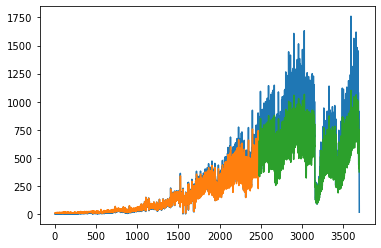

Epoch 1/5
2472/2472 - 3s - loss: 0.0030
Epoch 2/5
2472/2472 - 2s - loss: 0.0015
Epoch 3/5
2472/2472 - 2s - loss: 0.0014
Epoch 4/5
2472/2472 - 2s - loss: 0.0014
Epoch 5/5
2472/2472 - 2s - loss: 0.0014
Train Score: 63.42 RMSE
Test Score: 241.63 RMSE


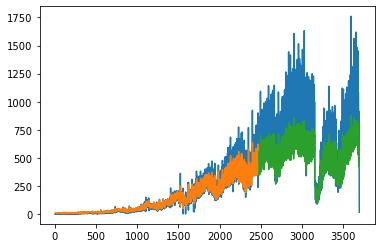

Epoch 1/5
2472/2472 - 3s - loss: 0.0021
Epoch 2/5
2472/2472 - 3s - loss: 0.0016
Epoch 3/5
2472/2472 - 3s - loss: 0.0015
Epoch 4/5
2472/2472 - 3s - loss: 0.0015
Epoch 5/5
2472/2472 - 3s - loss: 0.0014
Train Score: 64.10 RMSE
Test Score: 227.65 RMSE


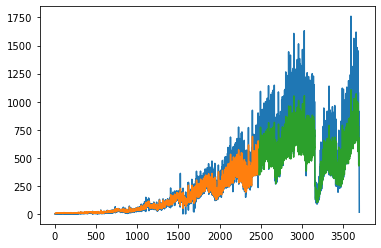

In [52]:
# LSTM Network for Regression
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 1, 
              epochs = 5)

# LSTM for Regression Using the Window Method
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 3, 
              epochs = 5)

# LSTM for Regression with Time Steps
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 3, 
              epochs = 5, 
              type_ = 'regression with time steps')

In [ ]:
# # LSTM with Memory Between Batches
# do_lstm_model(df = df_prophet, 
#               ts = 'y', 
#               look_back = 3, 
#               epochs = 5, 
#               type_ = 'memory between batches')

# # Stacked LSTMs with Memory Between Batches
# do_lstm_model(df = df_prophet, 
#               ts = 'y', 
#               look_back = 3, 
#               epochs = 5, 
#               type_ = 'stacked with memory between batches')